# Genome Shots

Browser shots.

**Inputs**: 
1. Config:
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
2. Bigwig files per cluster

In [42]:
library(ggplot2)
library(Gviz)
library(GenomicRanges)
library(patchwork)
library(ggplotify)
library(rtracklayer)

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Loading Inputs

### Day and Cluster Configs

In [3]:
day_config = read.table("./configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D0,D0,#A61C24
D2,D2,#FF70A6
D4,D4,#D6E82F
D6,D6,#B14AED
D8,D8,#2D3142
D10,D10,#FC7753
D12,D12,#0AABB7
D14,D14,#336699


In [4]:
cluster_config = read.table("./configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[11, "description"] = "Partially\nreprogrammed"

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#F4D5CD,Intermediate,12
2,2,#78A824,Pre-iPSC,15
3,3,#F01D35,Fibroblast-like,5
4,4,#E85F6D,Fibroblast-like,3
5,5,#B03743,Fibroblast,1
6,6,#7C2730,Fibroblast,2
7,7,#CF175A,Fibroblast-like,4
8,8,#CCCCCC,Doublets,17
9,9,#F7A6C2,Keratinocyte-like,6


### BigWig List

In [5]:
cluster_bigwigs = read.table("./configs/cluster_bigwigs.tsv", header=T)
cluster_bigwigs$path = as.character(cluster_bigwigs$path)
rownames(cluster_bigwigs) = cluster_bigwigs$cluster
head(cluster_bigwigs)

,cluster,path
,<int>,<chr>
1,1,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx1/signal/rep1/cluster_idx1.pval.signal.bigwig
2,2,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx2/signal/rep1/cluster_idx2.pval.signal.bigwig
3,3,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx3/signal/rep1/cluster_idx3.pval.signal.bigwig
4,4,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx4/signal/rep1/cluster_idx4.pval.signal.bigwig
5,5,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx5/signal/rep1/cluster_idx5.pval.signal.bigwig
6,6,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx6/signal/rep1/cluster_idx6.pval.signal.bigwig


### Gene Model

In [6]:
gencode.basic.hg38 = import.gff(gzfile("../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]
gene_anno = gene_anno[gene_anno$gene_type=="protein_coding", ]

# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

gene_anno$feature = as.character(gene_anno$type)
gene_anno$exon = gene_anno$exon_id
gene_anno = gene_anno[,c("chromosome", "start", "end", "strand", "gene", "symbol", "transcript", "feature", "exon")]
head(gene_anno)

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


,chromosome,start,end,strand,gene,symbol,transcript,feature,exon
,<fct>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
57,chr1,65419,65433,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003812156.1
58,chr1,65520,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813641.1
59,chr1,65565,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813641.1
60,chr1,65565,65567,+,ENSG00000186092.6,OR4F5,OR4F5-202,start_codon,ENSE00003813641.1
61,chr1,69037,71585,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813949.1
62,chr1,69037,70005,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813949.1


## Plotting

In [7]:
get_region_tracks <- function(chr, cluster_config, cluster_bigwigs, show_axis=T) {
    bw_tracks = c()
    for (i in seq(nrow(cluster_config))) {
        cur_bw_path = cluster_bigwigs[i, "path"]
        cur_bw_track = DataTrack(cur_bw_path, 
                             genome="hg38", 
                             chromosome = chr, 
                             name=sprintf("%s", cluster_config[i, "new_cluster"]),
                             ylim=c(0,42),
                             type="histogram",
                             col.histogram=cluster_config[i, "colour"],
                             background.title = cluster_config[i, "colour"], littleTicks=F)
        
        # don't show axis ticks for each plot
        displayPars(cur_bw_track)$showAxis = F
        if (!show_axis) {
            displayPars(cur_bw_track)$showTitle = F
        }
        
        bw_tracks = c(bw_tracks, cur_bw_track)
    }
    
    bw_tracks = bw_tracks[order(cluster_config$new_cluster)] # reorder
    
    if (!show_axis) {
            displayPars(gene_track)$showTitle = F
            displayPars(gene_track)$showAxis = F
        }
    
    bw_tracks
}

get_gene_track <- function(chr, gene_anno, show_axis=T) {
    gene_track <- GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = chr, 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent',
                                fill='#000000',
                                stackHeight=0.5)
    if (!show_axis) {
            displayPars(gene_track)$showTitle = F
        }
    
    gene_track
}

### Prototype

In [27]:
bw_tracks = get_region_tracks("chr16",cluster_config[1:2,], cluster_bigwigs, show_axis=T)

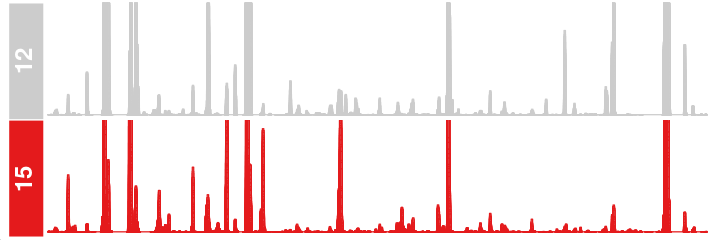

In [28]:
options(repr.plot.width = 6, repr.plot.height = 2)
as.ggplot(~plotTracks(bw_tracks, from=68720914, to=68851918))

In [17]:
gene_track = GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = "chr16", 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent')

gene_track2 = GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = "chr16", 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent',
                             stackHeight=0.5, fill='#000000', min.height=20)

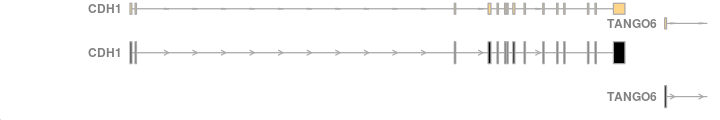

In [18]:
options(repr.plot.width = 6, repr.plot.height = 1)

as.ggplot(~plotTracks(c(gene_track, gene_track2), from=68720914, to=68851918, sizes=c(1,3)))

## Fig1 Panels

In [45]:
HIGHLIGHT_COL = "#f5f5f5"

In [69]:
bw_tracks = get_region_tracks("chr17", cluster_config, cluster_bigwigs, show_axis=T)
gene_track = get_gene_track("chr17", gene_anno, show_axis=T)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(50186797, 50201208, 50203706), 
                               end=c(50188860, 50202306, 50204438), 
                               chromosome="chr17",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

COL1A1 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track),
                               from=50180384, to=50205975,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("COL1A1") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [65]:
bw_tracks = get_region_tracks("chr11", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr11", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(102797862, 102791480), 
                               end=c(102798831, 102792130), 
                               chromosome="chr11",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

MMP1 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track),
                               from=102788090, to=102800775,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("MMP1") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [68]:
bw_tracks = get_region_tracks("chr16", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr16", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(68731000, 68777300), 
                               end=c(68740000, 68780500), 
                               chromosome="chr16",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

CDH1 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                             from=68720914, to=68851918, 
                             sizes=rep(1,nrow(cluster_config)+1))) +
       ggtitle("CDH1") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
             panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [62]:
bw_tracks = get_region_tracks("chr12", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr12", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(7787300), 
                               end=c(7789900), 
                               chromosome="chr12",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

NANOG = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), from=7783273, to=7805263,
                             sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("NANOG") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [56]:
bw_tracks = get_region_tracks("chr6", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr6", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(31170331), 
                               end=c(31173736), 
                               chromosome="chr6",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


POU5F1 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=31160139, to=31184929,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("OCT4") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [75]:
cluster_label_df = cluster_config

BOTTOM_PT = nrow(cluster_label_df)+0.7

cluster_label_df[nrow(cluster_label_df)+1, ] = c(nrow(cluster_label_df)+1, "", "", 1)
cluster_label_df[nrow(cluster_label_df)+1, ] = c(nrow(cluster_label_df)+1, "", "", BOTTOM_PT)

# need to play around with these parameters to find the right fit
cluster_labels_plot <- ggplot(cluster_label_df) +
    geom_text(aes(x=0, y= -as.numeric(new_cluster), label=description, hjust=1, vjust=0.5)) +
    theme_void() +
    theme(plot.margin = unit(c(0,-95,0,0), "pt"))

# add to debug- shows how ggplot dots align with genome track labels
# for (i in seq(1,18)) {
#     cluster_labels_plot = cluster_labels_plot + geom_point(x=0, y= -i)
# }

# cluster_labels_plot = cluster_labels_plot + geom_point(x=0, y= -BOTTOM_PT, colour='red')

In [76]:
myplot = wrap_plots(cluster_labels_plot,
                    COL1A1,
                    plot_spacer(),                    
                    MMP1,
                    plot_spacer(),
                    CDH1,
                    plot_spacer(),
                    NANOG,
                    plot_spacer(),
                    POU5F1,
                    widths=c(3,5,0,5,0,5,0,5,0,5))

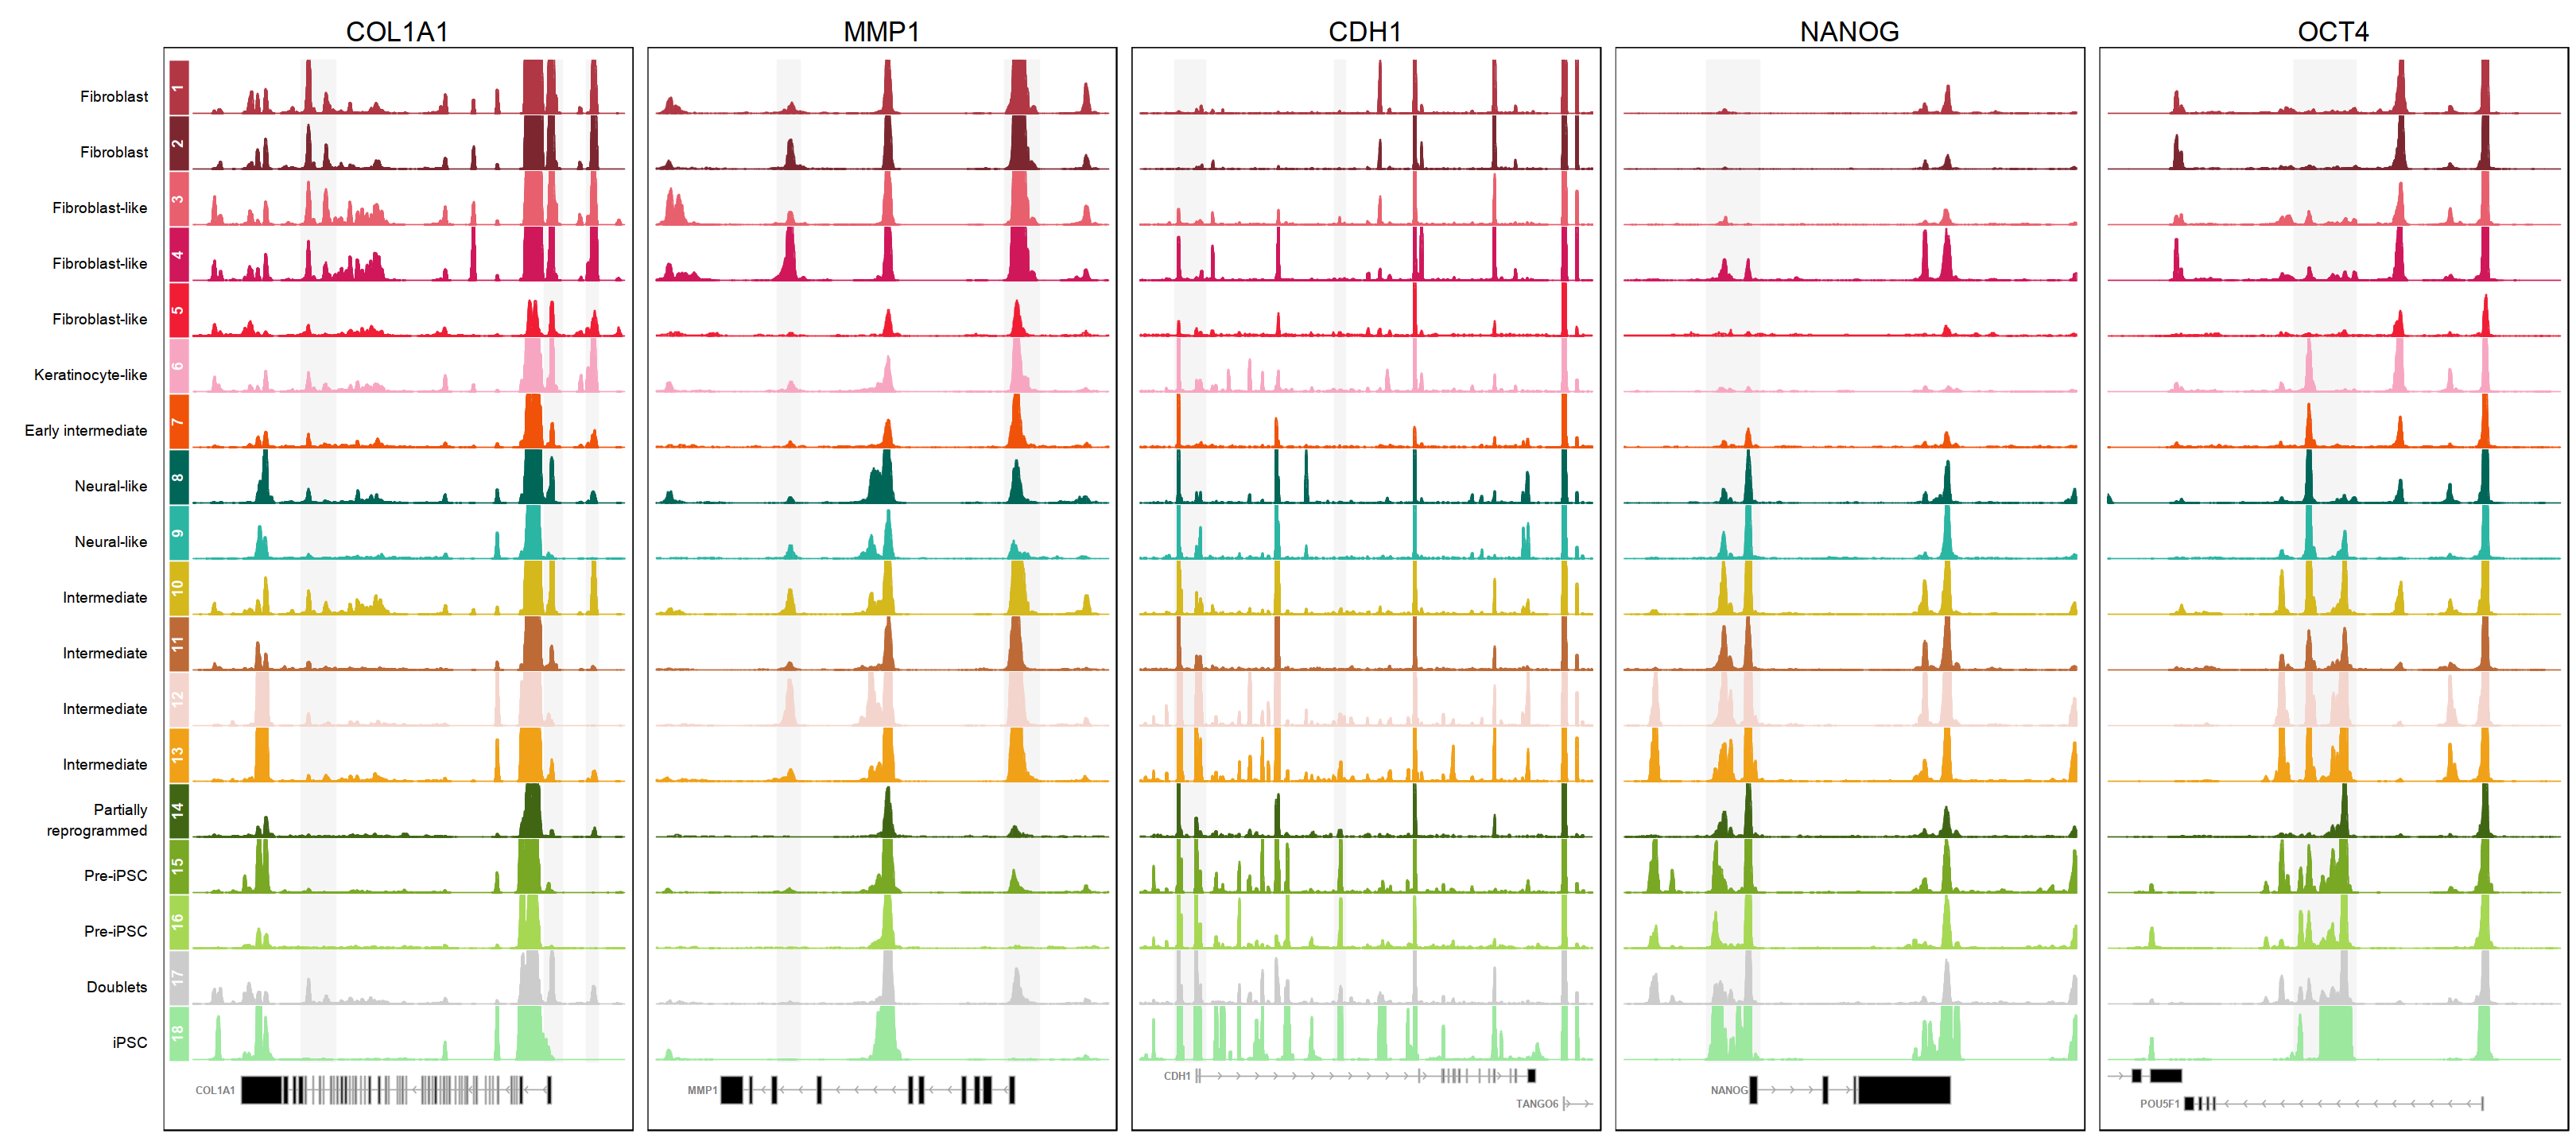

In [77]:
options(repr.plot.width = 27, repr.plot.height = 12)

myplot

In [78]:
saveRDS(COL1A1, file=sprintf("./Fig1/subfigs/%s_COL1A1.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(MMP1, file=sprintf("./Fig1/subfigs/%s_MMP1.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(CDH1, file=sprintf("./Fig1/subfigs/%s_CDH1.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(NANOG, file=sprintf("./Fig1/subfigs/%s_NANOG.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(POU5F1, file=sprintf("./Fig1/subfigs/%s_OCT4.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(cluster_labels_plot, file=sprintf("./Fig1/subfigs/%s_browser_labels.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [88]:
ggsave("tmp.png", myplot, height=12, width=27)

## Fig2 Panels

In [79]:
bw_tracks = get_region_tracks("chr2", cluster_config, cluster_bigwigs, show_axis=T)
gene_track = get_gene_track("chr2", gene_anno, show_axis=T)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(209566734), 
                               end=c(209626252), 
                               chromosome="chr2",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


MAP2 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=209382919, to=209743439,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("MAP2") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [80]:
bw_tracks = get_region_tracks("chr5", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr5", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(147646055, 147767684, 147778363), 
                               end=c(147649831, 147771200, 147785395), 
                               chromosome="chr5",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


JAKMIP2 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=147554719, to=147813263,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("JAKMIP2") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [81]:
bw_tracks = get_region_tracks("chr17", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr17", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(41612394), 
                               end=c(41613305), 
                               chromosome="chr17",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


KRT16 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=41606899, to=41614485,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("KRT16") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [82]:
bw_tracks = get_region_tracks("chr19", cluster_config, cluster_bigwigs, show_axis=F)
gene_track = get_gene_track("chr19", gene_anno, show_axis=F)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(51026182), 
                               end=c(51027891), 
                               chromosome="chr19",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


KLK11 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=51020832, to=51028608,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("KLK11") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [83]:
myplot = wrap_plots(cluster_labels_plot,
                    MAP2,
                    plot_spacer(),
                    JAKMIP2,
                    plot_spacer(),
                    KRT16,
                    plot_spacer(),
                    KLK11, widths=c(3,6,0,6,1,6,0,6))

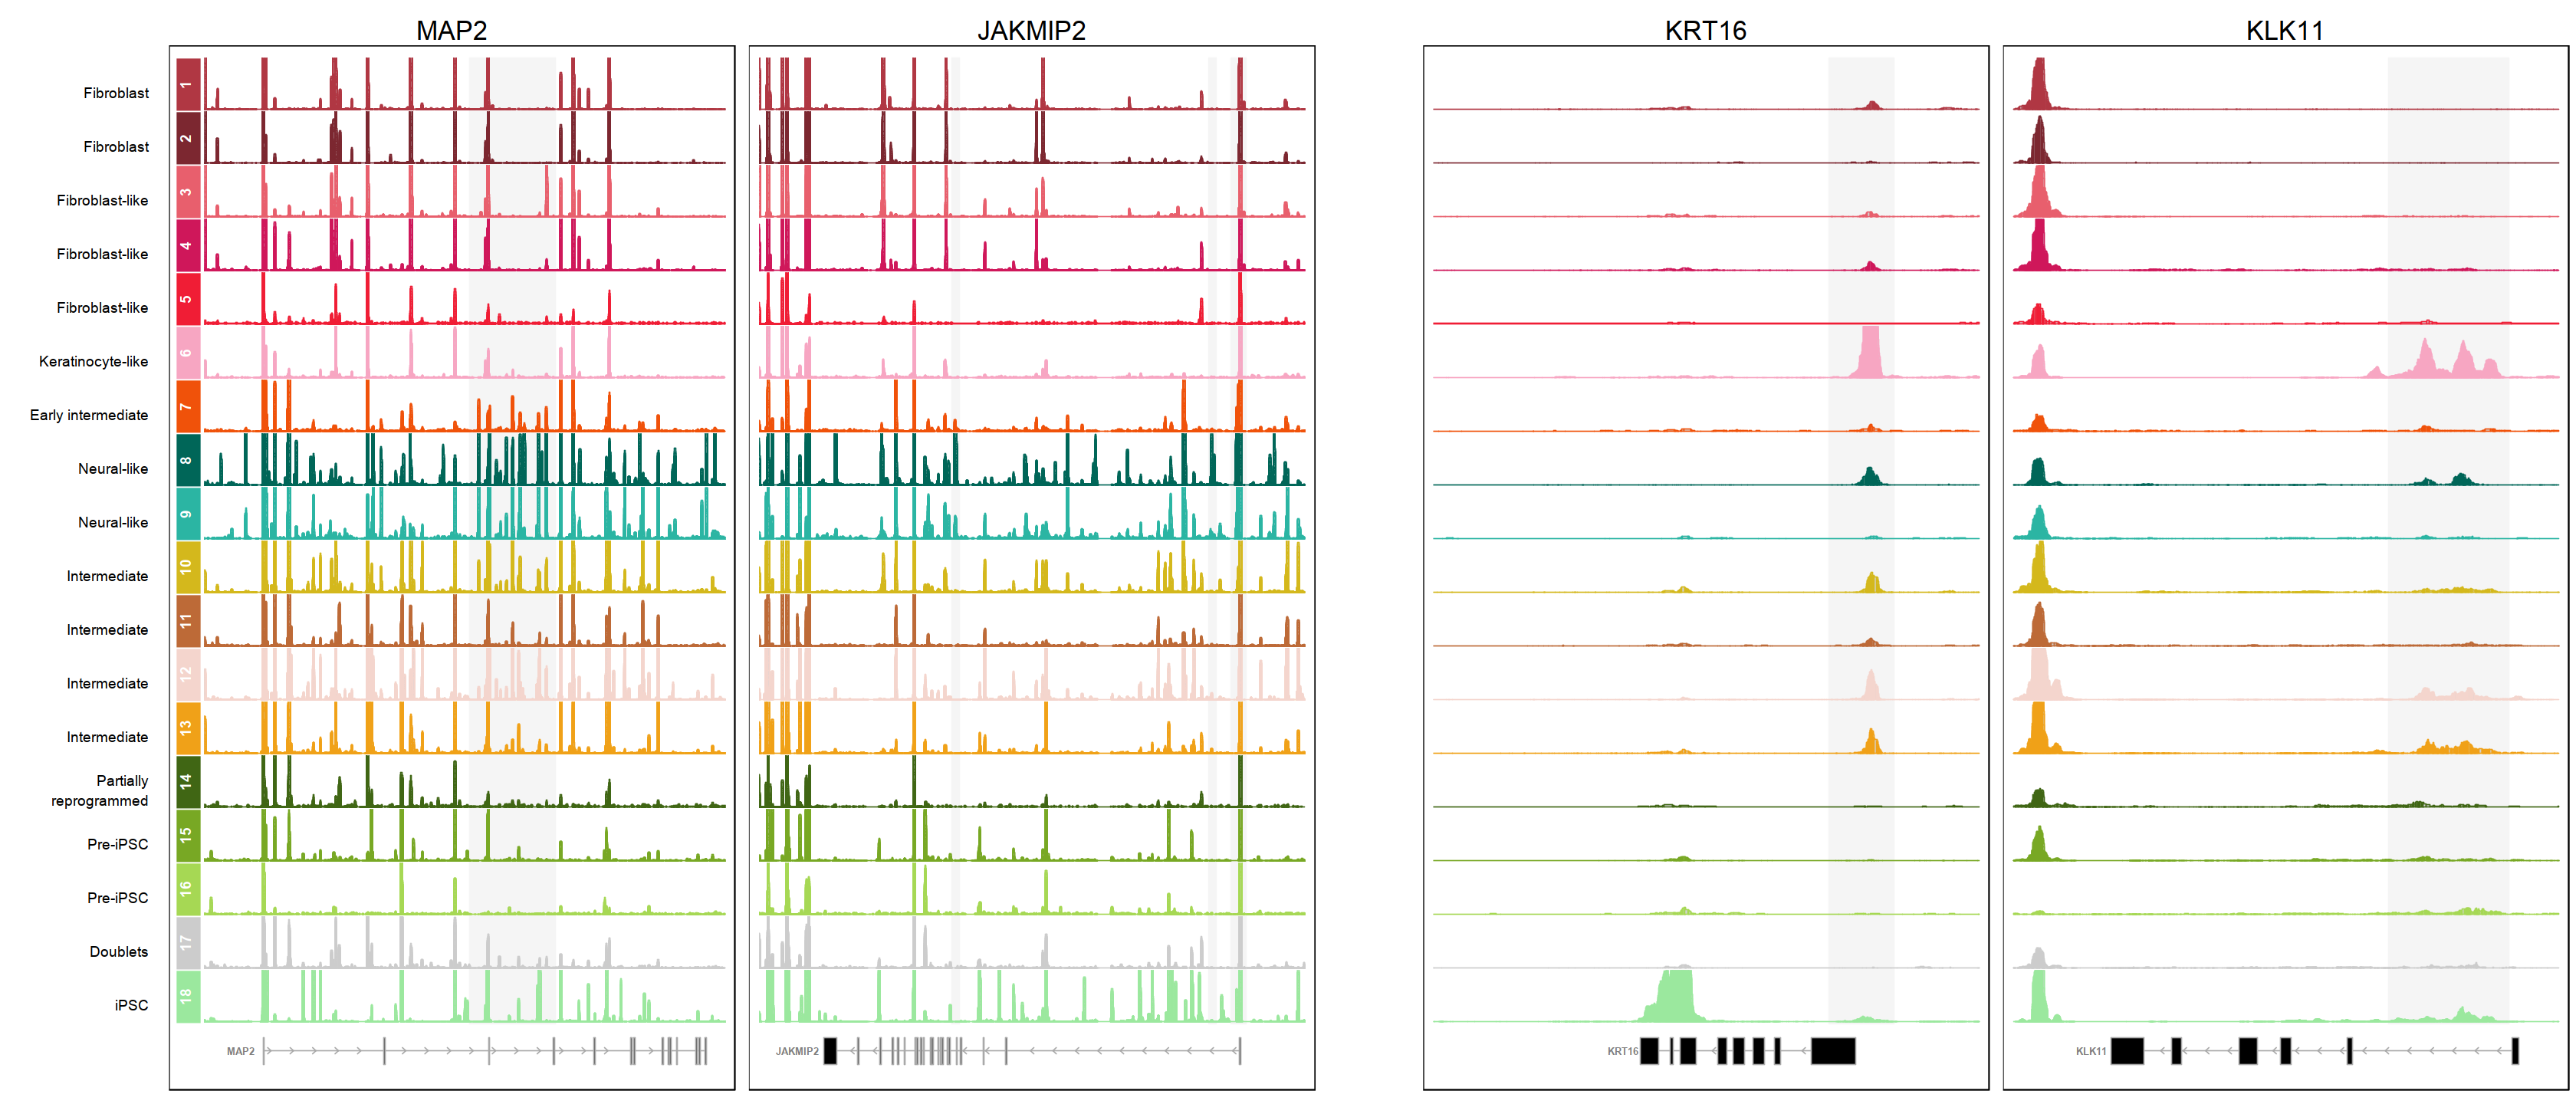

In [84]:
options(repr.plot.width = 28, repr.plot.height = 12)

myplot

In [85]:
saveRDS(MAP2, file=sprintf("./Fig2/subfigs/%s_MAP2.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(JAKMIP2, file=sprintf("./Fig2/subfigs/%s_JAKMIP2.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(KRT16, file=sprintf("./Fig2/subfigs/%s_KRT16.rds",
                                   format(Sys.Date(), "%Y%m%d")))
saveRDS(KLK11, file=sprintf("./Fig2/subfigs/%s_KLK11.rds",
                                   format(Sys.Date(), "%Y%m%d")))
# saveRDS(cluster_labels_plot, file=sprintf("./Fig2/subfigs/%s_browser_labels.rds",
#                                    format(Sys.Date(), "%Y%m%d")))

In [111]:
ggsave("tmp.png", myplot, height=12, width=15)

## Fig3 Panels

In [143]:
bw_tracks = get_region_tracks("chr20", cluster_config, cluster_bigwigs, show_axis=T)

gene_track = get_gene_track("chr20", gene_anno, show_axis=T)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(51775218, 51807938, 51811026, 51793768, 51802180,51799803), 
                               end=c(51776101, 51808171, 51811234, 51794010, 51802882, 51801841), 
                               chromosome="chr20",
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)


SALL4 = as.ggplot(~plotTracks(c(bw_highlighted, gene_track), 
                               from=51774290, to=51814020,
                               title.width=0.6,
                              sizes=rep(1,nrow(cluster_config)+1)))+
#        ggtitle("KLK11") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [144]:
myplot = wrap_plots(cluster_labels_plot,
                    SALL4, widths=c(2.7,12.3))

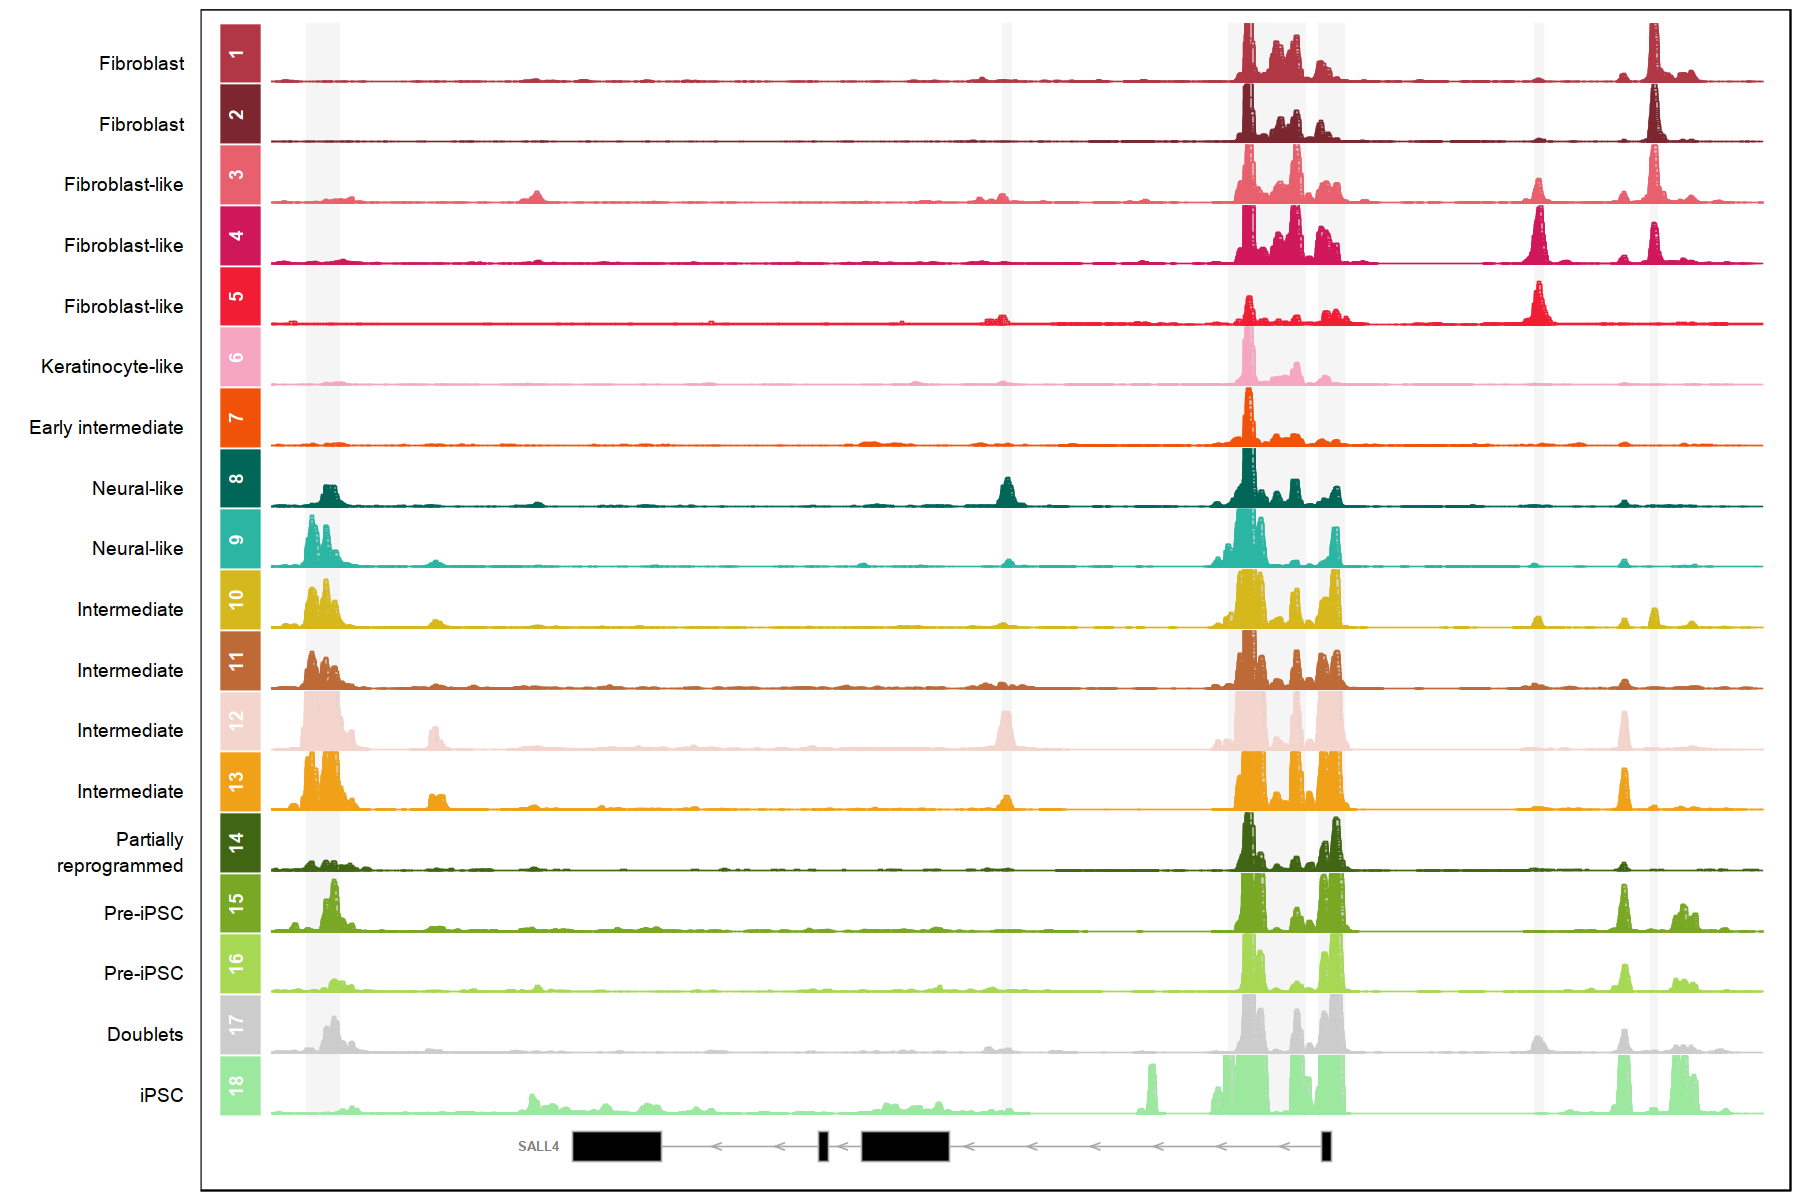

In [145]:
options(repr.plot.width = 15, repr.plot.height = 10)
myplot

In [148]:
saveRDS(SALL4, file=sprintf("./Fig3/subfigs/%s_locus.rds",
                                format(Sys.Date(), "%Y%m%d")))